In [1]:
dpath = "/content/drive/MyDrive/datasets/"
rpath = f"{dpath}requirements.txt"
!pip install -q -r {rpath}

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
!pip install -q tqdm datasets

In [4]:
!pip install git+https://github.com/huggingface/transformers.git

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-hgl29p34
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-hgl29p34
  Resolved https://github.com/huggingface/transformers.git to commit e5fd865ebae062b7cf03a81b8c6affeb39f30bec
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.48.0.dev0-py3-none-any.whl size=10329101 sha256=2b26d6b57b83c0bc4b77bb9ef33ef3045b6c6f8246e383ce1d4c714a90d5d93e
  Stored in directory: /tmp/pip-ephem-wheel-cache-my2dc4a0/wheels/e7/9c/5b/e1a9c8007c343041e61cc484433d512ea9274272e3fcbe7c16
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.47.1
    Uninstalling transformers-4.47.1:
      Successfully uninstalled transformers-4.47.1


In [1]:
import nltk
import evaluate
import numpy as np
from datasets import load_dataset
import os,torch
from huggingface_hub import HfFolder, login

In [2]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig, ModernBertModel,AdamW
from transformers import  AutoConfig, AutoModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, auc, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
import torch.nn as nn

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [4]:
df = pd.read_csv("/content/combined_txpf.csv")

In [5]:
from datasets import Dataset
ds = Dataset.from_pandas(df)

In [ ]:
ds

Dataset({
    features: ['label', 'comment_text', 'source'],
    num_rows: 126339
})

In [ ]:
filtered_sample = df[df['source'].isin(['ctx', 'tpf'])].sample(n=10, random_state=42)

In [ ]:
filtered_sample

In [24]:
from mbrtclassifier import *
from dataprocessing import *

# Model specific config

In [17]:
from evalmetrics import plot_metrics

def evaluate_model(model, data_loader, device, class_weights=None, criterion=None):
    """
    Uses softmax to convert the logits  to probablities
    Gets the class with highest propability using argmax
    """
    model.eval()
    total_loss = 0
    all_preds,all_labels,all_probs,all_indices = [],[],[],[]

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            indices = batch['idx']

            logits, _ = model(input_ids, attention_mask)
            if criterion is not None:
                loss = criterion(logits, labels)
                total_loss += loss.item()

            probs = torch.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
            all_indices.extend(indices.numpy())

    metrics = {
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs,
        'indices': all_indices,
        'recall': recall_score(all_labels, all_preds),
        'loss': total_loss / len(data_loader) if criterion is not None else None
    }

    return metrics

def train_model(config,model,train_loader, val_loader, test_loader, num_epochs=10,patiencestep=3,lrate=2e-5,weight_decay=0.01,factorrate=0.1,max_norm=1.0):
    """
    uses LR scheduler to reduce learning rate when the validation metric (recall) plateaus. This helps to fine-tune the model and prevent overfitting.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    class_weights = config['class_weights'].to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = AdamW(model.parameters(), lr=lrate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=factorrate, patience=patiencestep, verbose=True
    )

    # early stopping and metrics initialization
    best_val_recall = 0
    patience = patiencestep
    patience_counter = 0

    early_stopping = EarlyStopping(patience=patiencestep)

    train_losses,val_losses,val_recalls,all_labels,all_probs = [],[],[],[],[]

    for epoch in range(config['epochs']):
        print(f'\nEpoch {epoch + 1}/{config["epochs"]}')

        # Training Mode
        model.train()
        total_train_loss = 0

        for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs, _ = model(input_ids, attention_mask, labels-labels)

            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_norm)
            optimizer.step()

            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation Mode
        val_metrics = evaluate_model(
            model,
            val_loader,
            device,
            class_weights,
            criterion
        )
        val_losses.append(val_metrics['loss'])
        val_recalls.append(val_metrics['recall'])

        # Assign val_preds from the validation metrics returned in val_metrics
        val_preds = val_metrics['predictions']
        val_labels = val_metrics['labels']

        all_labels.extend(val_metrics['labels'])
        all_probs.extend(val_metrics['probabilities'])

        print(f'Epoch {epoch + 1}:')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {val_metrics["loss"]:.4f}')
        print('\nValidation Classification Report:')
        print(classification_report(val_labels, val_preds))
        #print(f'Val Recall: {val_metrics["recall"]:.4f}')

        scheduler.step(val_metrics['recall'])

        if val_metrics['recall'] > best_val_recall:
            best_val_recall = val_metrics['recall']
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

    # Final evaluation on test set
    test_metrics = evaluate_model(
        model,
        test_loader,
        device,
        class_weights,
        criterion
    )

    print('\nTest Set Results:')
    print(f'Test Loss: {test_metrics["loss"]:.4f}')
    print('\nTest Classification Report:')
    print(classification_report(test_metrics['labels'], test_metrics['predictions']))

    # Plot confusion matrix
    plot_metrics(train_losses, val_losses, all_labels, all_probs, val_preds, test_metrics)

    return train_losses, val_losses, val_recalls, model

In [19]:
config = {
    'model_name': 'answerdotai/ModernBERT-base',
    'max_length': 128,
    'batch_size': 32,
    'learning_rate': 2e-5,
    'epochs': 10,
    'dropout_rate': 0.2,
    'hidden_dropout_rate': 0.3,
    'outputmdlpath' : '/content/drive/MyDrive/ftmodernbrta',

}

In [ ]:
ds_df = df

In [10]:
df.columns.value_counts()

,count
label,1
comment_text,1
source,1


In [20]:
#Calculate class weights
labelcol = 'label'
class_weights = calculate_class_weights(df[labelcol].values)
config['class_weights'] = class_weights
print("\nClass Weights:")
print(class_weights)

# Calculate class distribution
class_distribution = df[labelcol].value_counts()
print("\nClass Distribution:")
print(class_distribution)
print("\nClass Distribution (%):")
print(class_distribution / len(df) * 100)


Class Weights:
tensor([0.7641, 1.4466])

Class Distribution:
label
0    82672
1    43667
Name: count, dtype: int64

Class Distribution (%):
label
0    65.436643
1    34.563357
Name: count, dtype: float64


In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tokenizer = AutoTokenizer.from_pretrained("answerdotai/ModernBERT-base")
# Initialize
model = CustomModernBERTClassifier().to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training set size: 75803
Validation set size: 25268
Test set size: 25268

Epoch 1/10


Epoch 1/10: 100%|██████████| 4738/4738 [17:20<00:00,  4.55it/s]


Epoch 1:
Training Loss: 0.1710
Validation Loss: 0.1535

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     16534
           1       0.96      0.93      0.94      8734

    accuracy                           0.96     25268
   macro avg       0.96      0.95      0.96     25268
weighted avg       0.96      0.96      0.96     25268


Epoch 2/10


Epoch 2/10: 100%|██████████| 4738/4738 [17:20<00:00,  4.55it/s]


Epoch 2:
Training Loss: 0.0907
Validation Loss: 0.1418

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     16534
           1       0.92      0.96      0.94      8734

    accuracy                           0.96     25268
   macro avg       0.95      0.96      0.96     25268
weighted avg       0.96      0.96      0.96     25268


Epoch 3/10


Epoch 3/10: 100%|██████████| 4738/4738 [17:20<00:00,  4.55it/s]


Epoch 3:
Training Loss: 0.0439
Validation Loss: 0.2458

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     16534
           1       0.95      0.94      0.94      8734

    accuracy                           0.96     25268
   macro avg       0.96      0.95      0.96     25268
weighted avg       0.96      0.96      0.96     25268


Epoch 4/10


Epoch 4/10: 100%|██████████| 4738/4738 [17:19<00:00,  4.56it/s]


Epoch 4:
Training Loss: 0.0246
Validation Loss: 0.2680

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     16534
           1       0.95      0.94      0.94      8734

    accuracy                           0.96     25268
   macro avg       0.96      0.96      0.96     25268
weighted avg       0.96      0.96      0.96     25268


Epoch 5/10


Epoch 5/10: 100%|██████████| 4738/4738 [17:20<00:00,  4.55it/s]


Epoch 5:
Training Loss: 0.0191
Validation Loss: 0.2524

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     16534
           1       0.94      0.95      0.94      8734

    accuracy                           0.96     25268
   macro avg       0.96      0.96      0.96     25268
weighted avg       0.96      0.96      0.96     25268

Early stopping triggered!

Test Set Results:
Test Loss: 0.2632

Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     16535
           1       0.95      0.94      0.94      8733

    accuracy                           0.96     25268
   macro avg       0.96      0.96      0.96     25268
weighted avg       0.96      0.96      0.96     25268



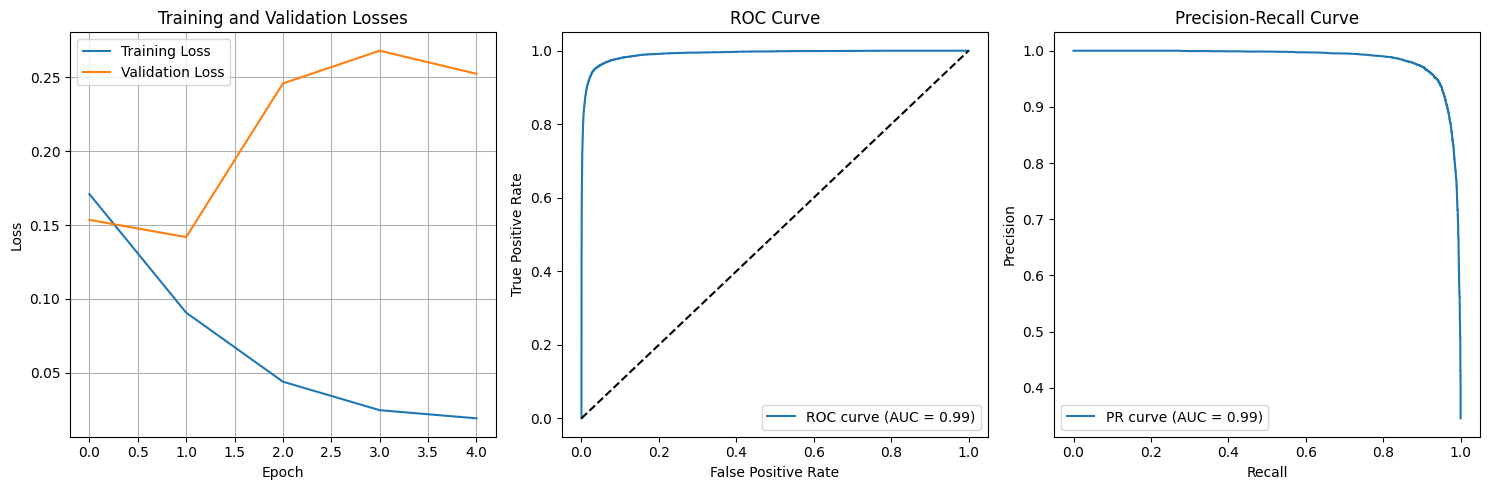

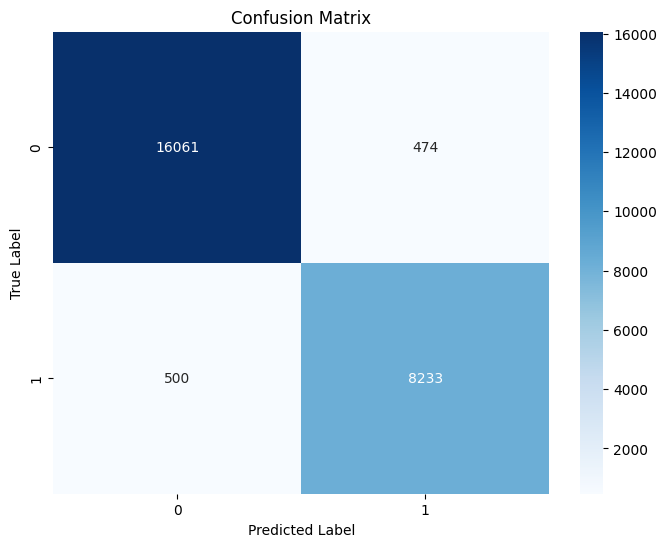

In [27]:
train_dataset, val_dataset, test_dataset = create_data_splits(
        texts=ds['comment_text'],
        labels=ds['label'],
        tokenizer=tokenizer,
        test_size=0.20,
        val_size=0.25
    )

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=16
)
test_loader = DataLoader(
    test_dataset,
    batch_size=16
)

# train model
train_losses, val_losses, val_recalls, _ = train_model(
     config, model, train_loader, val_loader, test_loader
  )

# Load best model and evaluate by loading model weights onto the correct device
state_dict = torch.load('best_model.pt', map_location=device, weights_only=True)

# Load  weights and other necessary state information into the model
model.load_state_dict(state_dict)

test_metrics = evaluate_model(model, test_loader, device)

In [29]:
# Save the model and tokenizer
OUTPUT_DIR = '/content/drive/MyDrive/ftmodernbrta'
# Save the model weights using torch.save
torch.save(model.state_dict(), f"{OUTPUT_DIR}/pytorch_model.bin")
# Save the tokenizer
tokenizer.save_pretrained(OUTPUT_DIR)
print(f"Model weights saved to {OUTPUT_DIR}/pytorch_model.bin")
print(f"Tokenizer saved to {OUTPUT_DIR}")

model.config.save_pretrained(OUTPUT_DIR) # Save the model config
print(f"Model config saved to {OUTPUT_DIR}/config.json")

Model weights saved to /content/drive/MyDrive/ftmodernbrta/pytorch_model.bin
Tokenizer saved to /content/drive/MyDrive/ftmodernbrta
Model config saved to /content/drive/MyDrive/ftmodernbrta/config.json


In [ ]:
plot_metrics(train_losses, val_losses, test_metrics['labels'], test_metrics['probabilities'], val_recalls, test_metrics)


In [56]:
from evalmetrics import analyze_errors, display_error_analysis

In [57]:
  # Analyze errors
  org_dataset = ProcessDataset(texts=ds['comment_text'],
                          labels=ds['label'],
                          tokenizer=tokenizer)
  false_positives, false_negatives = analyze_errors(test_metrics, test_dataset=org_dataset)

In [58]:
display_error_analysis(false_positives, false_negatives)


=== False Positives (Non-toxic classified as Toxic) ===
Total False Positives: 687

1. Index: 432
Text: The proposed rewrite has been placed into the article Hence the article no longer claims that the Bleach liner photos were shot at Maxwell s
Confidence: 1.000

2. Index: 21653
Text: Wanna have dirty nasty sex Firebringervt
Confidence: 1.000

3. Index: 16169
Text: Something complex is most certainly going on here
Confidence: 1.000

4. Index: 2404
Text: Ditto I am overwhelmed by the number of nasty vicious self important and unhelpful self appointed editors on Wikipedia
Confidence: 1.000

5. Index: 3613
Text: Holy Shit Holy shit
Confidence: 1.000

=== False Negatives (Toxic classified as Non-toxic) ===
Total False Negatives: 356

1. Index: 801
Text: Don t kiss these hoes in the mouth Unless you have to

2. Index: 22591
Text: MeSheWILL Bring winter back This degrees at am shit is for the birds Get The Fukkk Outta Here Bro

3. Index: 8916
Text: Ugly bitches like to argue a lot

4. Index

In [98]:
import warnings
warnings.filterwarnings("ignore")
def infer_modernbertsentencevalidator(contextstr, mdlpath='/content/drive/MyDrive/ftmodernbrta/'):
    try:
        ft_model = CustomModernBERTClassifier()
        binpath = mdlpath + '/pytorch_model.bin'
        if os.path.exists(binpath):
            ft_model.load_state_dict(torch.load(binpath))
            ft_model.eval()
            tokenizer = AutoTokenizer.from_pretrained(mdlpath)
            result = {}

            result['contextstr'] = contextstr
            with torch.no_grad():
                #Tokenize inputs
                inputs = tokenizer(contextstr, return_tensors="pt")
                output = ft_model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
                # get the outputtensor
                evallabel = output[0].argmax().item()
                result['evallabel'] = evallabel
                if evallabel==1:
                  result['prediction'] = 'offensive'
                else:
                  result['prediction'] = 'non-offensive'
            return result

    except Exception as e:
        return (f"Encountered error while performing inference: {e}")

In [99]:
infer_modernbertsentencevalidator(contextstr="Ugly women like to argue a lot")

{'contextstr': 'Ugly women like to argue a lot',
 'evallabel': 1,
 'prediction': 'offensive'}

In [100]:
infer_modernbertsentencevalidator(contextstr="you worst fellow")

{'contextstr': 'you worst fellow',
 'evallabel': 0,
 'prediction': 'non-offensive'}

In [101]:
infer_modernbertsentencevalidator(contextstr="Yo bag Gucci but you still ugly hoe shut up")

{'contextstr': 'Yo bag Gucci but you still ugly hoe shut up',
 'evallabel': 1,
 'prediction': 'offensive'}

In [102]:
infer_modernbertsentencevalidator(contextstr="suggest best strategies to ease stress")

{'contextstr': 'suggest best strategies to ease stress',
 'evallabel': 0,
 'prediction': 'non-offensive'}

In [103]:
infer_modernbertsentencevalidator(contextstr="I'm so fed and vexed up with this bullshit!")

{'contextstr': "I'm so fed and vexed up with this bullshit!",
 'evallabel': 1,
 'prediction': 'offensive'}

In [104]:
infer_modernbertsentencevalidator(contextstr="Hello n@@@@@!")

{'contextstr': 'Hello n@@@@@!', 'evallabel': 1, 'prediction': 'offensive'}

In [105]:
infer_modernbertsentencevalidator(contextstr="Please do not vandalize pages as you did with this edit to City of Melbourne If you continue to do so you will be blocked from editing talk")

{'contextstr': 'Please do not vandalize pages as you did with this edit to City of Melbourne If you continue to do so you will be blocked from editing talk',
 'evallabel': 0,
 'prediction': 'non-offensive'}

In [106]:
infer_modernbertsentencevalidator(contextstr="Hello n##s!")

{'contextstr': 'Hello n##s!', 'evallabel': 1, 'prediction': 'offensive'}

In [107]:
infer_modernbertsentencevalidator(contextstr="Hello n#g#!")

{'contextstr': 'Hello n#g#!', 'evallabel': 1, 'prediction': 'offensive'}

In [108]:
infer_modernbertsentencevalidator(contextstr="f**********@@@@22**** off !")

{'contextstr': 'f**********@@@@22**** off !',
 'evallabel': 1,
 'prediction': 'offensive'}

In [109]:
infer_modernbertsentencevalidator(contextstr="I can do anything to you get it to your head and backoff now!")

{'contextstr': 'I can do anything to you get it to your head and backoff now!',
 'evallabel': 0,
 'prediction': 'non-offensive'}

In [110]:
infer_modernbertsentencevalidator(contextstr="You are not a genius to express your views you should stay within your limits!")

{'contextstr': 'You are not a genius to express your views you should stay within your limits!',
 'evallabel': 0,
 'prediction': 'non-offensive'}

In [111]:
infer_modernbertsentencevalidator(contextstr="It is a wonderfulday!")

{'contextstr': 'It is a wonderfulday!',
 'evallabel': 0,
 'prediction': 'non-offensive'}

In [112]:
testlist=["You worst idiot","We dont need genius people we need people who can gel with others you should understand your limits", "You are asshole","You bloody nasty fellow",
          "You are pretty", "Its a bright morning", "its been a great pleasure talking to you",
          "You shut up and don't change my contributions!!!!", "shit-faced loser screw you",
          "I hate to talk to you", "you're blanking my comments you idiot you will pay for this",
          "He is a devil", "Exactly. Problem solved you moron", "You sounded like a fag the last three days",
          "Cursed how much everything happens on earth", "Few people do not have good hygiene",
          "You all should be locked or deserted alone", "Yo bag Gucci but you still ugly hoe shut up",
          "will you jus shut off I dont think we need your opinion there are several great folks here",
          "I'm so damn tired of this endless bullshit!", "I can't believe that jerk would do that for you",
          "Shut the f*** off and shut off now", "This is absolute bullshit you should leave that asshole", "you're crazy stiff", "What the F**** that stuppid told me to wait",
          "I cant get that idiot screwed it again why dont he die", "She is a bloody woman aiming for him ha my foot", "You will get what you deserve you should stay within your limits not aim high for your life"
          ]

In [113]:
resultdict = {'contextstr': [], 'evallabel': [], 'predictionresult': []}

for s in testlist:
    t = infer_modernbertsentencevalidator(contextstr=s)
    resultdict['contextstr'].append(s)
    resultdict['evallabel'].append(t['evallabel'])
    resultdict['predictionresult'].append(t['prediction'])
resultdf = pd.DataFrame(resultdict)

# MODERNBERTA RESULTS

In [80]:
resultdf

,contextstr,evallabel,predictionresult
0,You worst idiot,1,offensive
1,We dont need genius people we need people who can gel with others you should understand your limits,0,non-offensive
2,You are asshole,1,offensive
3,You bloody nasty fellow,1,offensive
4,You are pretty,0,non-offensive
5,Its a bright morning,0,non-offensive
6,its been a great pleasure talking to you,0,non-offensive
7,You shut up and don't change my contributions!!!!,1,offensive
8,shit-faced loser screw you,1,offensive
9,I hate to talk to you,0,non-offensive
